<a href="https://colab.research.google.com/github/carlosarroyave/AutoEnc-GAN/blob/main/AE-GAMCAm%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import keras
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import layers
!pip install tf-keras-vis tensorflow
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear, ExtractIntermediateLayer
from tf_keras_vis.utils.scores import CategoricalScore, InactiveScore
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from matplotlib import cm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.4 MB/s eta 0:00:00


In [2]:
def plot_mnist_autoencoder(x,xpred,cmap='gray',vmin=0,vmax=1):
  fig,ax = plt.subplots(2,x.shape[0],figsize=(20,5))
  for i,class_ in enumerate(range(x.shape[0])):
        ax[0,i].imshow(x[i],cmap=cmap,vmin=vmin,vmax=vmax)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])

        ax[1,i].imshow(xpred[i],cmap=cmap,vmin=vmin,vmax=vmax)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
  plt.show()
  return

## DataSet utlizado de keras fashion_mnist

El dataset esta calsificado en las siguientes clases :  # T-shirt/top, 	Trouser, Pullover,	Dress, 	Coat, Sandal, Shirt, 	Sneaker, Bag, Ankle boot

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


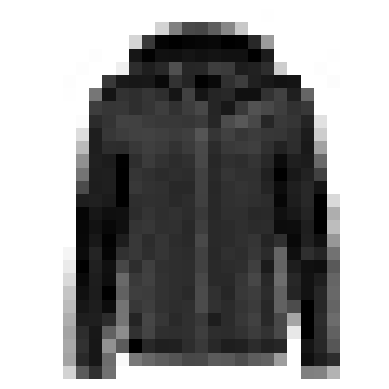

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

Se mezclan los datos para garantizar que el modelo no tenga overfitting por el orden de los datos en el entrenamiento.

In [4]:
tamano = len(X_train)
indice_mezcla = np.random.permutation(tamano)
x_tr = X_train[indice_mezcla].reshape([tamano,28,28,1])
y_train = y_train[indice_mezcla]
tamano = len(X_valid)
indice_mezcla = np.random.permutation(tamano)
x_vl = X_valid[indice_mezcla].reshape([tamano,28,28,1])
y_valid = y_valid[indice_mezcla]
tamano = len(X_test)
indice_mezcla = np.random.permutation(tamano)
x_ts = X_test[indice_mezcla].reshape([tamano,28,28,1])
y_test = y_test[indice_mezcla]

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)


# Modelo Autoencoder con detección

Se crea un modelo de autoencoder que comparte la capa latente con otra red de clasificación para las 10 clases que se tienen

![Arquitectura](https://github.com/carlosarroyave/AutoEnc-GAN/blob/main/ArqAE_Dis.png?raw=1)

In [ ]:

# input image dimensions
img_rows, img_cols = 28, 28
input_shape = (28,28,1)

#arquitectura funcional
keras.backend.clear_session()



# Definición de la entrada utilizando la API funcional de Keras
input_l = layers.Input(shape=(28,28,1), name='entrada')

# Capas convolucionales y de pooling para la parte Ecoder del modelo
ATO_Layer1_conv1       = layers.Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=input_shape)(input_l)
ATO_Layer2_conv2       = layers.Conv2D(32, kernel_size=(3, 3),activation='relu')(ATO_Layer1_conv1)
ATO_Layer3_maxp1       = layers.MaxPooling2D(pool_size=(2, 2))(ATO_Layer2_conv2)
ATO_Layer4_Dropout1    = layers.Dropout(0.1)(ATO_Layer3_maxp1)
ATO_Layer5_conv3       = layers.Conv2D(64, kernel_size=(3, 3),activation='relu')(ATO_Layer4_Dropout1)
ATO_Layer6_conv4       = layers.Conv2D(128, kernel_size=(3, 3),activation='relu')(ATO_Layer5_conv3)
ATO_Layer7_maxp2       = layers.MaxPooling2D(pool_size=(2, 2))(ATO_Layer6_conv4)
ATO_Layer8_Dropout2    = layers.Dropout(0.1)(ATO_Layer7_maxp2)
# Capas para la parte latente del modelo
ATO_Layer9_Flatten1    = layers.Flatten()(ATO_Layer8_Dropout2)
ATO_Layer10_Dense1     = layers.Dense(256, activation='relu')(ATO_Layer9_Flatten1)

# Capas deconvolucionales para la parte decoder del modelo
ATO_Layer11_Reshape1   = layers.Reshape([16,16,1])(ATO_Layer10_Dense1)
ATO_Layer12_conv5      = layers.Conv2DTranspose(32, kernel_size=(5, 5),activation='relu')(ATO_Layer11_Reshape1)
ATO_Layer13_conv6      = layers.Conv2DTranspose(16, kernel_size=(5, 5),activation='relu')(ATO_Layer12_conv5)
ATO_Layer14_conv7      = layers.Conv2DTranspose(1, kernel_size=(5, 5),activation='relu')(ATO_Layer13_conv6)
ATO_Layer15_Reshape2   = layers.Reshape([28,28,1])(ATO_Layer14_conv7)

# Capas densas adicionales para etapa de clasificación
ATO_Layer1_Dense1    = layers.Dense(128, activation='relu')(ATO_Layer10_Dense1)
ATO_Layer2_Dense2    = layers.Dense(64, activation='relu')(ATO_Layer1_Dense1)
ATO_Layer3_Dense3    = layers.Dense(10, activation='softmax')(ATO_Layer2_Dense2)

model_fun = tf.keras.Model(inputs=input_l,outputs=[ATO_Layer15_Reshape2, ATO_Layer3_Dense3])
model_fun.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 entrada (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 26, 26, 16)           160       ['entrada[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 24, 24, 32)           4640      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
model_fun.compile(loss=["MSE","CategoricalCrossentropy"],
              optimizer="Adam",
              metrics="accuracy")


history = model_fun.fit(x_tr, [x_tr,y_train] , epochs=10,batch_size=64,
                    validation_split=0.3)

Epoch 1/10
602/602 [==============================] - 196s 321ms/step - loss: 0.6443 - reshape_1_loss: 0.0544 - dense_3_loss: 0.5898 - reshape_1_accuracy: 0.4956 - dense_3_accuracy: 0.7787 - val_loss: 0.4629 - val_reshape_1_loss: 0.0377 - val_dense_3_loss: 0.4252 - val_reshape_1_accuracy: 0.5016 - val_dense_3_accuracy: 0.8476
Epoch 2/10
602/602 [==============================] - 183s 304ms/step - loss: 0.3992 - reshape_1_loss: 0.0375 - dense_3_loss: 0.3617 - reshape_1_accuracy: 0.5013 - dense_3_accuracy: 0.8677 - val_loss: 0.3537 - val_reshape_1_loss: 0.0334 - val_dense_3_loss: 0.3203 - val_reshape_1_accuracy: 0.5024 - val_dense_3_accuracy: 0.8797
Epoch 3/10
602/602 [==============================] - 203s 337ms/step - loss: 0.3390 - reshape_1_loss: 0.0336 - dense_3_loss: 0.3054 - reshape_1_accuracy: 0.5024 - dense_3_accuracy: 0.8877 - val_loss: 0.3653 - val_reshape_1_loss: 0.0330 - val_dense_3_loss: 0.3323 - val_reshape_1_accuracy: 0.5017 - val_dense_3_accuracy: 0.8738
Epoch 4/10
602/6

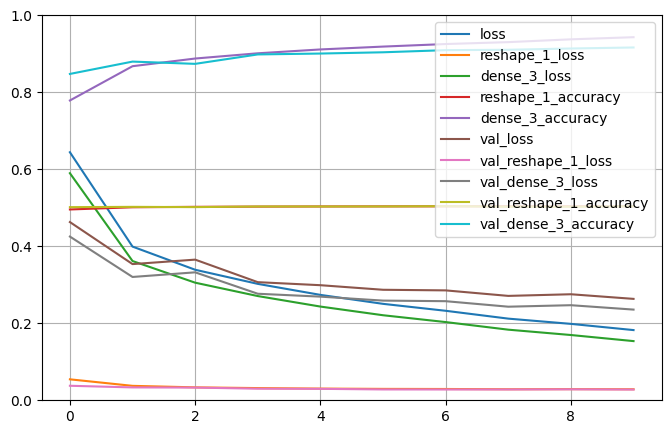

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

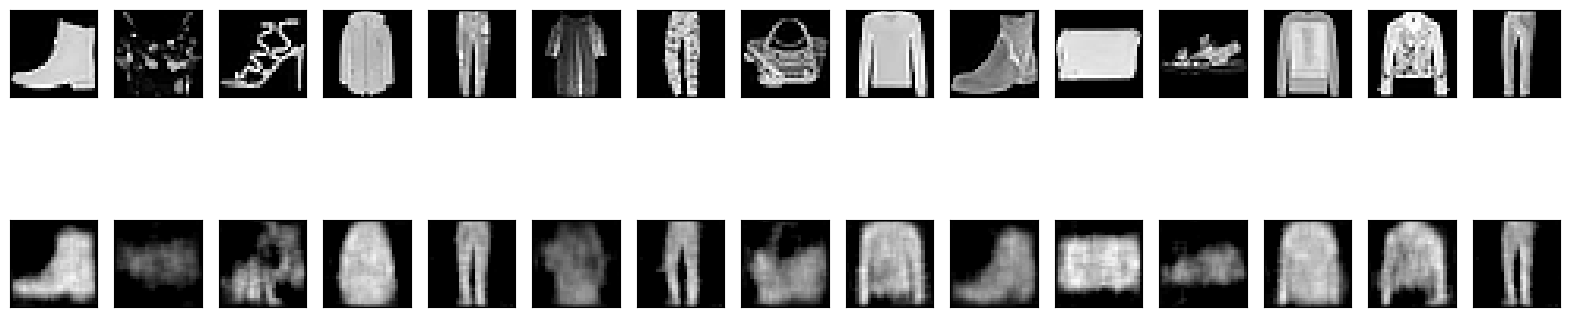

Y_real:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Y_pred:  tf.Tensor(
[[8.99022037e-11 5.74164105e-10 1.19824229e-11 8.22641469e-11
  1.98582453e-11 3.10130105e-07 4.49025150e-10 2.35936586e-05
  2.98885812e-11 9.99975979e-01]
 [1.11207388e-01 7.97487082e-05 5.79727057e-04 7.50595791e-05
  1.03592738e-05 8.72751534e-01 1.98900420e-03 1.01218733e-03
  1.19732525e-02 3.21638276e-04]
 [7.36273993e-17 4.14345109e-20 9.90720844e-22 1.38891300e-23
  7.16490964e-24 9.99999940e-01 4.45144642e-22 5.36262386e-14
  8.71005837e-22 3.54418512e-15]
 [2.

In [ ]:
x_prueb = x_ts[:15,:,:,:]
c=model_fun(x_prueb)
plot_mnist_autoencoder(x_ts[:15],c[0])
print("Y_real: ",y_test[0:15,:])
print("Y_pred: ", c[1])

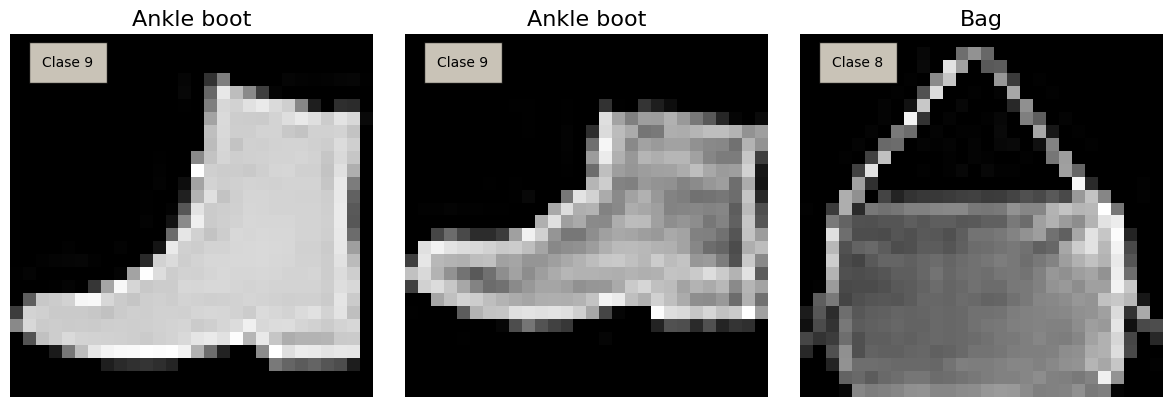

In [ ]:
# Image titles
clases_y = ["T-shirt/top", "Trouser", "Pullover",	"Dress", 	"Coat", "Sandal", "Shirt", 	"Sneaker", "Bag", "Ankle boot"]
 # T-shirt/top, 	Trouser, Pullover,	Dress, 	Coat, Sandal, Shirt, 	Sneaker, Bag, Ankle boot

# Load images and Convert them to a Numpy array
img1 = x_ts[0,:,:,0]
img2 = x_ts[200,:,:,0]
img3 = x_ts[1300,:,:,0]
images = np.array([img1, img2, img3])

# Imagenes de prueba para GradCAM++
Img_GC = np.array([x_ts[0,:,:,:], x_ts[200,:,:,:], x_ts[1300,:,:,:]])

y_real = np.array([y_test[0,:],y_test[200,:], y_test[1300,:]])
c=model_fun(Img_GC)

y_classes = [np.argmax(y, axis=None, out=None) for y in c[1][:]]
image_titles = [ y for y in y_classes]
image_titles = [clases_y[y] for y in image_titles]
y_c_t = [np.argmax(y, axis=None, out=None) for y in y_real]
#x_prueb = x_ts[:15,:,:,:]
#c=model_fun(x_prueb)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i]*255, cmap="gray", vmin=0, vmax=255,)
    ax[i].text(2, 2, 'Clase {}'.format(y_classes[i]), bbox = {'facecolor': 'oldlace', 'alpha': 0.8, 'pad': 10})
    ax[i].axis('off')
plt.tight_layout()
plt.show()

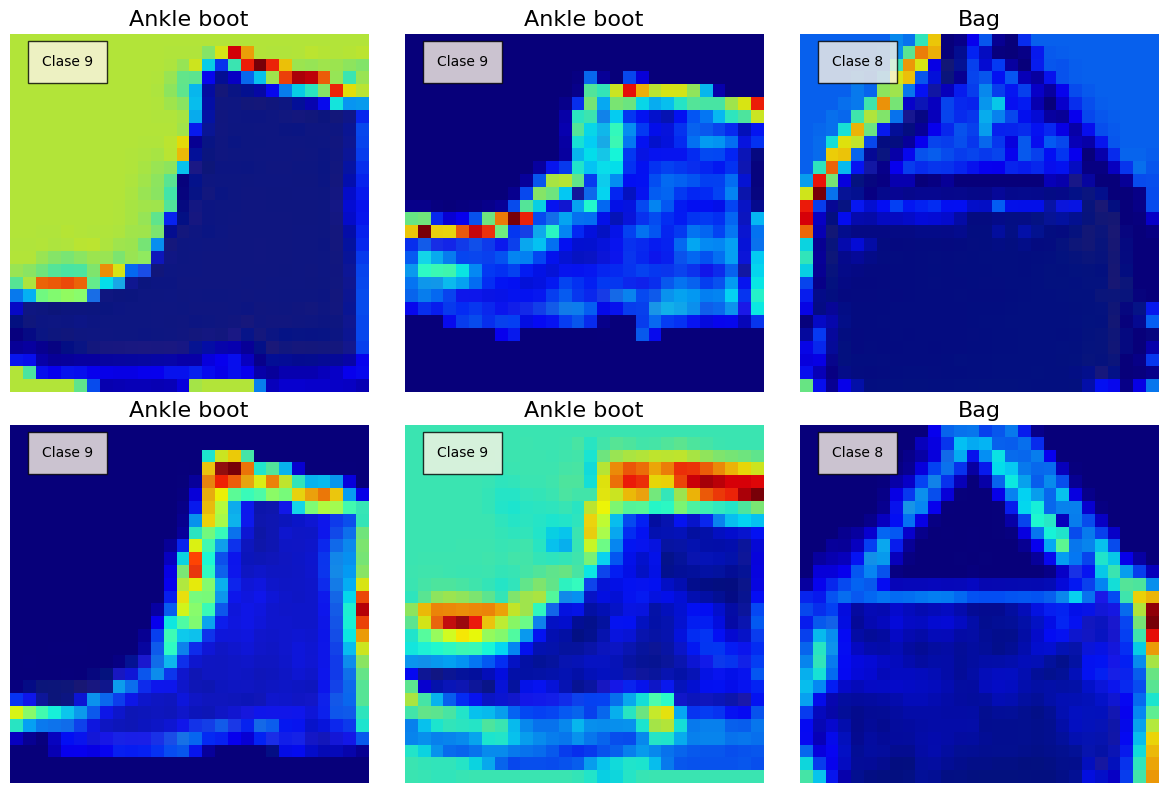

In [ ]:
replace2linear = ReplaceToLinear()
score = [CategoricalScore(y_classes) ]
N_layer = 2
N_img  = 3
#score = CategoricalScore([0,1])
# Create GradCAM++ object
gradcam = GradcamPlusPlus(model_fun,
                          model_modifier=[ExtractIntermediateLayer('dense_3'),
                                        ReplaceToLinear()])

#Nombres de las capas del modelo['entrada', 'conv2d', 'conv2d_1', 'max_pooling2d', 'dropout', 'conv2d_2', 'conv2d_3', 'max_pooling2d_1', 'dropout_1', 'flatten', 'dense', 'reshape', 'conv2d_transpose', 'conv2d_transpose_1', 'dense_1', 'conv2d_transpose_2', 'dense_2', 'reshape_1', 'dense_3']


# Render
f, ax = plt.subplots(nrows=N_layer, ncols=N_img, figsize=(12, 8))
for j in range(N_layer):
    cam = gradcam(score,Img_GC,penultimate_layer=(j+1))
    for i,title in enumerate(image_titles):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3]*255 )
        ax[j,i].set_title(title, fontsize=16)
        ax[j,i].imshow(images[i])
        ax[j,i].imshow(heatmap, cmap='jet', alpha=0.9)
        ax[j,i].text(2, 2, 'Clase {}'.format(y_classes[i]), bbox = {'facecolor': 'oldlace', 'alpha': 0.8, 'pad': 10})
        ax[j,i].axis('off')
plt.tight_layout()
plt.show()